In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
data1 = loadmat('data/compEx1data.mat')
x = data1['x']
x1s = x[0][0]
x2s = x[1][0]

data2 = loadmat('data/compEx2data.mat')
K = data2['K']

In [3]:
def normalize_points(points, K):
    K_inv = np.linalg.inv(K)
    normalized_points = K_inv @ points
    return normalized_points

def enforce_essential(E_approx):
    U, S, Vt = np.linalg.svd(E_approx)
    S = np.array([1,1,0])
    E = U @ np.diag(S) @ Vt
    return E

def convert_E_to_F(E, K1, K2):
    K1_inv = np.linalg.inv(K1)
    K2_inv = np.linalg.inv(K1)
    F = K2_inv.T @ E @ K1_inv
    return F

def estimate_E_DLT(x1s, x2s,K, path, tolerance=1e-2, norm=True):
    x1n = normalize_points(x1s,K)
    x2n = normalize_points(x2s,K)
    M = []
    for i in range(x1n.shape[1]):
        x1, y1, _ = x1n[:, i]
        x2, y2, _ = x2n[:, i]
        M.append([x2 * x1, x2 * y1, x2, y2 * x1, y2 * y1, y2, x1, y1, 1])
    M = np.array(M)

    U, S, Vt = np.linalg.svd(M)
    v = Vt[-1]
    E_approx = v.reshape(3, 3)

    min_singular_value = S[-1]
    residual = np.linalg.norm(M @ v)
    print(f"Minimum singular value: {min_singular_value}")
    print(f"Residual ||M v||: {residual}")
    
    E = enforce_essential(E_approx)

    epipolar_constraints = np.einsum('ij,ji->i', x2n.T, E @ x1n)

    
    print("Essential Matrix:")
    print(E)

    plot_epipolar_constraints(epipolar_constraints,path)
    
    return E

def compute_epipolar_errors(F, x1s, x2s):
    l2 = F @ x1s
    l2 /= np.sqrt(l2[0, :]**2 + l2[1, :]**2)

    distances = np.abs(np.sum(l2 * x2s, axis=0))
    return distances

def plot_epipolar_lines(image, points, epipolar_lines, path):
    plt.imshow(image, cmap='gray')
    plt.scatter(points[0, :], points[1, :], c='red', marker='o', s=15)

    for i in range(epipolar_lines.shape[1]):
        a, b, c = epipolar_lines[:, i]
        x = np.linspace(0, image.shape[1], 100)
        y = -(a * x + c) / b
        plt.plot(x, y)

    plt.xlim(0,1936)
    plt.ylim(1296,0)
    plt.savefig(path)
    plt.show()

def plot_epipolar_constraints(epipolar_constraints,path):
    plt.figure(figsize=(8, 6))
    plt.hist(epipolar_constraints, bins=50, edgecolor='black')
    plt.title("Distribution of Epipolar Constraint Violations")
    plt.xlabel("Constraint Value (x2.T @ E @ x1)")
    plt.ylabel("Frequency")
    plt.savefig(path)
    plt.show()


Minimum singular value: 0.006626799894543032
Residual ||M v||: 0.006626799894543127
Essential Matrix:
[[-3.19804783e-03 -3.61887189e-01  1.35671987e-01]
 [ 4.50655254e-01  2.81965445e-02 -8.80848110e-01]
 [-1.70108461e-01  9.17553777e-01  3.59797963e-04]]


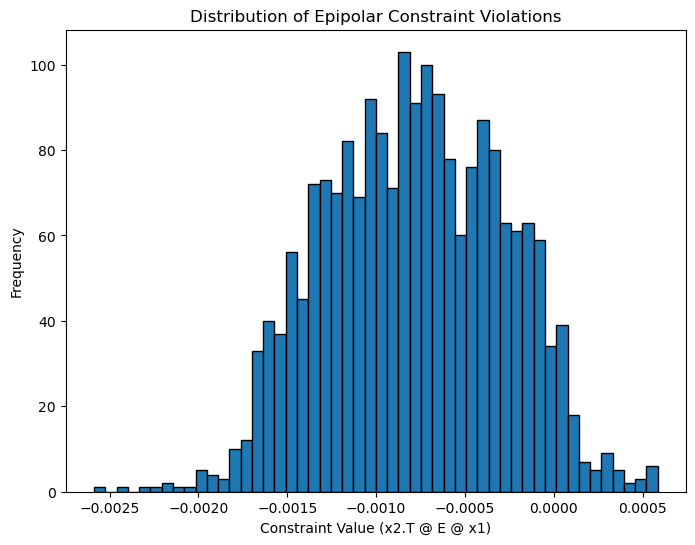

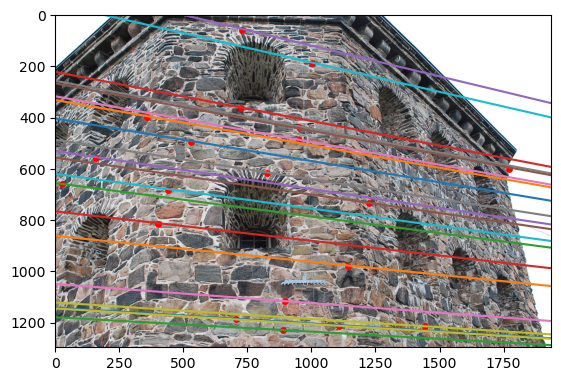

Mean distance from points to epipolar lines: 2.0837532026910877


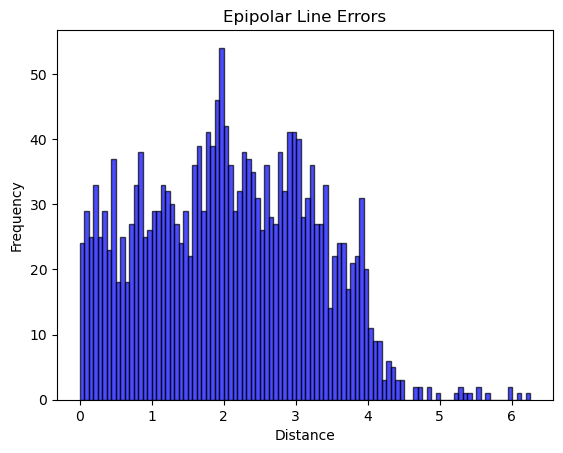

In [4]:
E = estimate_E_DLT(x1s, x2s, K, "figs/constraint_plot_ex2.png")

F = convert_E_to_F(E, K, K)

image2 = imread('data/kronan2.jpg')
random_indices = np.random.choice(x2s.shape[1], 20, replace=False)
points = x2s[:, random_indices]
epipolar_lines = F @ x1s[:, random_indices]

plot_epipolar_lines(image2, points, epipolar_lines, 'figs/epipolar_lines_ex2.png')

distances = compute_epipolar_errors(F, x1s, x2s)
mean_error = np.mean(distances)
print(f"Mean distance from points to epipolar lines: {mean_error}")

plt.hist(distances, bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Epipolar Line Errors')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.savefig("figs/hist_ex2.png")
plt.show()